# Example of generating a 1D2DRR model - an overview of functionalities

This notebook gives an overview of the functionalities of the D-HyDAMO module, part of the delft3dfmpy python package.

For install instructions see: https://github.com/openearth/delft3dfmpy#installation

Furthermore, it should be noted that recently added features were tested with dummy-data, which is included with this package. The generated model is, therefore, not necessarily a correct hydraulic representation, as some dummy structures were added and existing structures moved and/or adjusted. The purpose of this notebook is solely to illustrate the usage of the dhydamo module.

This notebook corresponds to a major update of delt3dfmpy and is, therefore, not compatible with older versions. The main differences are:
- input data should now be according the HyDAMO DAMO2.2 format instead of HyDAMO v12;
- input data is no longer in GML-format but is contained in a geopackage (GPKG);
- schematisation of paved nodes has changed. Within sewer areas, a paved node is created for every overflow location (which represents the corresponding fraction of the sewer area). Outside sewer areas, a paved node is created for the paved fraction of a catchment, which does NOT intersect with a sewage area;
- where the example catchment for older versions was the Moergestelsbroek, now the example model is based on a part of the Oostrumsche beek.


## Initialize

Load Python libraries

In [25]:
# Basis
import os
import sys
import shutil
from platform import python_version
import numpy as np
sys.path.append('../')      
# Importing relevant classes from delft3dfmpy
from delft3dfmpy import DFlowFMModel, HyDAMO, Rectangular, DFlowFMWriter
from delft3dfmpy import DFlowRRModel, DFlowRRWriter
from delft3dfmpy.datamodels.common import ExtendedGeoDataFrame

# shapefiles IO
import geopandas as gpd

# Import csv
import pandas as pd

# Geometries
from shapely.geometry import Polygon, LineString, Point

# Plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

%matplotlib inline

Change these paths to access the data and to use all functionalities. dflowfm_path is needed to refine the 2D-grid. It is not included in the D-Hydro installation. In the next major update, we will use meshkernel functionality and this executable will no longer be needed.

In [26]:
# path to the package containing the dummy-data
data_path = os.path.abspath('../data')

# path to dflowfm. Optional; needed for 2d-mesh refining
dflowfm_path = r'D:\3640.20\software\dflowfm-x64-1.2.104.66827M'

# path to write the models
output_path = os.path.abspath('../modellen/oostrum_1D2DRR')

# path to DIMR for a correct run.bat file
dimr_path = r"C:\Program Files\Deltares\D-HYDRO Suite 2022.03 1D2D\plugins\DeltaShell.Dimr\kernels\x64\dimr\scripts\run_dimr.bat"

In [27]:
# path to dll's that are needed to run gridgeom.dll, which is needed for 2D-mesh generation. Setting the path is only needed for Python >= version 3.8
if float('.'.join(python_version().split('.')[0:2])) >= 3.8: 
    dll_path = r'C:\Program Files\Deltares\D-HYDRO Suite 2022.03 1D2D\plugins\DeltaShell.Dimr\kernels\x64\share\bin'


## Read HYDAMO

Along with the HyDAMO DAMO2.2 format, the format of input data changed from GML to GPKG. 
In the following, we initialize a hydamo-instance and show the content of the GPKG-file containing all DAMO2.2 data.

In [28]:
gpkg_file = os.path.join(data_path,'gpkg/Example_model.gpkg')
hydamo = HyDAMO(extent_file=os.path.join(data_path,'gis/OLO_subcatchment.shp'))
hydamo.branches.show_gpkg(gpkg_file)

Content of gpkg-file D:\3640.20\delft3dfmpy_master\data\gpkg/Example_model.gpkg, containing 18 layers:
	INDEX	|	NAME                        	|	GEOM_TYPE      	|	 NFEATURES	|	   NFIELDS
	    0	|	hydroobject                   	|	Line String 	|	        61	|	        35
	    1	|	stuw                          	|	3D Point    	|	        25	|	        41
	    2	|	duikersifonhevel              	|	3D Line String	|	        92	|	        44
	    3	|	gemaal                        	|	3D Point    	|	         1	|	         8
	    4	|	brug                          	|	Point       	|	         1	|	        10
	    5	|	pomp                          	|	Unknown (any)	|	         1	|	         9
	    6	|	sturing                       	|	Unknown (any)	|	         1	|	        17
	    7	|	kunstwerkopening              	|	Unknown (any)	|	       213	|	        16
	    8	|	hydrologischerandvoorwaarde   	|	Point       	|	         1	|	         8
	    9	|	regelmiddel                   	|	3D Point    	|	        27	|	        30


In the code section below the content of the GPKG is added. For more info on how to import its different elements, see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview

The general steps for importing a HyDAMO object are:
- Read the objects from the GPKG file.
- Snap the structures to the branches.
- Remove non-snapped structures, perhaps because the distance to the nearest branch was too large.

A few remarks:
- The converter requires a number of column names with a specfic name. If the name in the GPKG layer does not match this name, it can be converted with the 'column_mapping'
- The branch or structure data can also be loaded from shapefiles. Note that shapefiles have a max column length of 10 characters, so probably a lot of column_mapping is necessary.

In [29]:
# branches
hydamo.branches.read_gpkg_layer(gpkg_file, layer_name='HydroObject', index_col='code')

# these branches are not connected to the main branch and have no profile - drop them.
branches_to_drop = ['W_242466_0','W_242465_0','W_1386_0', 'W_1698_0', 'W_2352_0']
hydamo.branches.drop(branches_to_drop, axis=0, inplace=True)

# profile points. Profiles that are associated with structures are connected through profile_line and profile_group objects.
hydamo.profile.read_gpkg_layer(gpkg_file, layer_name='ProfielPunt', groupby_column = 'profiellijnid', order_column='codevolgnummer') 
hydamo.profile_roughness.read_gpkg_layer(gpkg_file, layer_name='RuwheidProfiel') 
hydamo.profile.snap_to_branch(hydamo.branches, snap_method='intersecting')
hydamo.profile.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.profile_line.read_gpkg_layer(gpkg_file, layer_name='profiellijn', id_col='globalid')
hydamo.profile_group.read_gpkg_layer(gpkg_file, layer_name='profielgroep')
hydamo.profile.drop('code', axis=1, inplace=True)
hydamo.profile.rename(columns={'profiellijnid': 'code'}, inplace=True)

# parametrised profile
hydamo.param_profile.read_gpkg_layer(gpkg_file, layer_name='hydroobject_normgp')
hydamo.param_profile_values.read_gpkg_layer(gpkg_file, layer_name='normgeparamprofielwaarde')

#culverts
hydamo.culverts.read_gpkg_layer(gpkg_file, layer_name='DuikerSifonHevel', index_col='code')
hydamo.culverts.snap_to_branch(hydamo.branches, snap_method='ends', maxdist=5)
hydamo.culverts.dropna(axis=0, inplace=True, subset=['branch_offset'])

# weirs - with associated 'kunstwerkopening' and 'regelmiddel'
hydamo.weirs.read_gpkg_layer(gpkg_file, layer_name='Stuw', index_col='code')
hydamo.weirs.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.weirs.dropna(axis=0, inplace=True, subset=['branch_offset'])
hydamo.opening.read_gpkg_layer(gpkg_file, layer_name='Kunstwerkopening')
hydamo.management_device.read_gpkg_layer(gpkg_file, layer_name='Regelmiddel')

# pumps
hydamo.pumpstations.read_gpkg_layer(gpkg_file, layer_name='Gemaal',index_col='code')
hydamo.pumpstations.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
hydamo.pumps.read_gpkg_layer(gpkg_file,layer_name='Pomp', index_col='code')
hydamo.pumps['maximalecapaciteit'] *= 60
hydamo.management.read_gpkg_layer(gpkg_file, layer_name='Sturing', index_col='code')

# bridge
hydamo.bridges.read_gpkg_layer(gpkg_file, layer_name='Brug', index_col='code')
hydamo.bridges.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=1100)
hydamo.bridges.dropna(axis=0, inplace=True, subset=['branch_offset'])

# boundary conditions
hydamo.boundary_conditions.read_gpkg_layer(gpkg_file, layer_name='hydrologischerandvoorwaarde', index_col='code')
hydamo.boundary_conditions.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=10)
    

For laterals, we add a the laterals' code field to the catchment dataframe as 'lateraleknoopcode'. This is an extra coupling because in HyDAMO DAMO2.2 laterals and catchments are coupled using a 16-digit string which is not usable in the model.

When the catchments contain MultiPolygons, they are split into multiple catchments. The resulting nodes then are connected to the same lateral.

In [30]:
hydamo.catchments.read_gpkg_layer(gpkg_file, layer_name='afvoergebiedaanvoergebied', index_col='code')
hydamo.laterals.read_gpkg_layer(gpkg_file,layer_name='lateraleknoop')
for ind, cat in hydamo.catchments.iterrows():
    hydamo.catchments.loc[ind,'lateraleknoopcode'] = hydamo.laterals[hydamo.laterals.globalid==cat.lateraleknoopid].code.values[0]
hydamo.laterals.snap_to_branch(hydamo.branches, snap_method='overal', maxdist=5000)

15.0 is MultiPolygon; split into single parts.
57.0 is MultiPolygon; split into single parts.
68.0 is MultiPolygon; split into single parts.
71.0 is MultiPolygon; split into single parts.
92.0 is MultiPolygon; split into single parts.
285.0 is MultiPolygon; split into single parts.
310.0 is MultiPolygon; split into single parts.
882.0 is MultiPolygon; split into single parts.


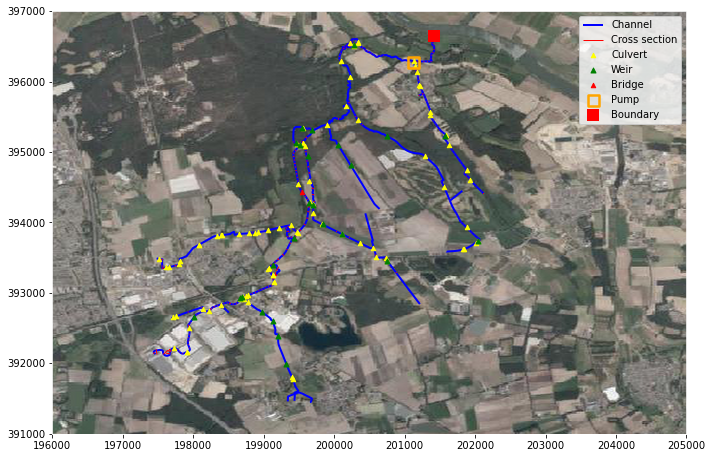

In [31]:
fn_background = os.path.join(data_path, 'gis', 'achtergrond_oostrum.png')
plt.rcParams['axes.edgecolor'] = 'w'

fig, ax = plt.subplots(figsize=(10, 10))

#ax.fill(*hydamo.clipgeo.exterior.xy, color='w', alpha=0.5)
#ax.xaxis.set_visible(False)
#ax.yaxis.set_visible(False)
#map_extent = [189287.43330048519419506,389693.68099274818086997, 210845.66716714628273621,398529.35119274590397254]
ax.set_xlim(196000, 205000)
ax.set_ylim(391000,397000)

achtergrond = plt.imread(fn_background)
ax.imshow(achtergrond, extent=(189287, 210845, 389693, 398529), interpolation='lanczos')

hydamo.branches.plot(ax=ax, label='Channel', linewidth=2, color='blue')
hydamo.profile.plot(ax=ax, color='red', label='Cross section', linewidth=1)
hydamo.culverts.centroid.plot(ax=ax, color='yellow', label='Culvert', markersize=20, zorder=10, marker='^')
hydamo.weirs.centroid.plot(ax=ax, color='green', label='Weir', markersize=25, zorder=10, marker='^')
hydamo.bridges.plot(ax=ax,color='red',label='Bridge',markersize=20,zorder=10, marker='^')
hydamo.pumpstations.plot(ax=ax, color='orange', label='Pump', marker='s', markersize=125, zorder=10, facecolor='none', linewidth=2.5)
hydamo.boundary_conditions.plot(ax=ax, color='red', label='Boundary', marker='s', markersize=125, zorder=10, facecolor='red', linewidth=0)
ax.legend()

fig.tight_layout()

## Generate the D-HYDRO FM schematisation

### 1D-network

We first import the structures from the HyDAMO-object, since the structures' positions are necessary for defining the position of the 1D-mesh. Structures can also be added without the HyDAMO imports. One weir is added manually as an example, but equivalent functions are available for all implemented structures.

Note that for importing most structures multiple objects are needed from the GPKG. For more info on how to add structures (directly or from HyDAMO), see: https://hkvconfluence.atlassian.net/wiki/spaces/DHYD/overview.

 - for weirs, a corresponding profile is looked up in the crossections. If one is found, the weir is implemented as a universal weir. If it is not found, a regular (rectangular) weir will be used. The cross-section ('hydamo.profile') should be related through 'hydamo.profile_line' to a 'hydamo.profile_group', which contains a 'stuwid' column which is equal to the GlobalID of the corresponding weir. The weir object can also include orifices, in that case the field 'overlaatonderlaat' in the 'management_device-object ('regelmiddel') is 'onderlaat'. For weirs it should be 'overlaat'.
 
 - for culverts, a regelmiddel can be used to model a 'schuif' and/or a 'terugslagklep'. This is specified by the field 'soortregelmiddel'. In case of a 'terugslagklep', the flow direction is set to 'positive' instead of 'both'. In case of a 'schuif', a valve is implemented. Note that in DAMO2.2, an 'afsluitmiddel' can contain the same information. For now, only a regelmiddel (management_device) is implemented. In a next version, the flexibility to use both will be included. 
 
 - bridges need an associated crosssection. This is idential to universal weirs, but here the 'hydamo.profile_group'-object should contain a field 'brugid'. 
 
 - pumps are composed from 'hydamo.pumpstations', 'hydamo.pumps' and 'hydamo.managmement'. Only suction-side drection is implemented. Maximal capacity should be in m3/min.

In most cases, these 'extra' arguments are optional, i.e. they are not required and can be left out. Some are required:
- pumps really need all 3 objects ('hydamo.pumpstations', 'hydamo.pumps' and 'hydamo.managmement');
- bridges really need an associated crosssection (see above);

For more info on the structure definitions one is referred to the D-Flow FM user manual: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.

In [32]:
# Collect structures
dfmmodel = DFlowFMModel()
dfmmodel.structures.io.weirs_from_hydamo(hydamo.weirs, profile_groups=hydamo.profile_group, profile_lines=hydamo.profile_line, profiles=hydamo.profile, opening=hydamo.opening, management_device=hydamo.management_device, management=None)
dfmmodel.structures.io.culverts_from_hydamo(hydamo.culverts, management_device=hydamo.management_device)
dfmmodel.structures.io.bridges_from_hydamo(hydamo.bridges, profile_groups=hydamo.profile_group, profile_lines=hydamo.profile_line, profiles=hydamo.profile)
dfmmodel.structures.io.pumps_from_hydamo(pompen=hydamo.pumps, sturing=hydamo.management, gemalen=hydamo.pumpstations)

It is also possible to add extra structures like this:

In [33]:
dfmmodel.structures.add_weir(
    id='extra_weir',
    branchid='W_242213_0',
    chainage=43.0,
    crestlevel=18.00,
    crestwidth=7.5,
    corrcoeff=1.0    
)

Add the branches and generate a 1D computational mesh.

In [34]:
dfmmodel.network.set_branches(hydamo.branches)
dfmmodel.network.generate_1dnetwork(one_d_mesh_distance=20.0, seperate_structures=True)

2022-06-20 13:45:38,719 - delft3dfmpy.core.dfm - dfm - WARNING - Some structures are not linked to a branch.
2022-06-20 13:45:38,722 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_1486_0 at: [0.0, 422.14700000000005, 593.3188859785391], due to the structures at [-0.001, 45.737, 64.128, 418.557, 425.737, 569.795, 593.3198859785391].
2022-06-20 13:45:38,725 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_153210_2 at: [0.0, 208.7465, 557.1781929021295], due to the structures at [-0.001, 203.426, 214.067, 255.862, 425.015, 557.1791929021294].
2022-06-20 13:45:38,728 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on branch W_2151_0 at: [0.0, 11.335, 39.908804212576065], due to the structures at [-0.001, 8.84, 13.83, 39.90980421257606].
2022-06-20 13:45:38,729 - delft3dfmpy.core.dfm - dfm - WARNING - Structures D_24521, D_14808 have the same location.
2022-06-20 13:45:38,735 - delft3dfmpy.core.dfm - dfm - INFO - Added 1d mesh nodes on b

Add cross sections. Here two hydamo files are used. First the imported cross sections. If after this there are branch objects left without a cross sections, it is derived from the norm parametrised profile (Dutch: legger).

DAMO2.2 contains two roughness variants, 'ruwheidhoog' en ruwheidlaag'. Using roughness_variant, "High", or "Low". we choose one.

In [35]:
# Add cross sections from hydamo
dfmmodel.crosssections.io.from_hydamo(
    crosssections=hydamo.profile,
    crossection_roughness=hydamo.profile_roughness,
    param_profile=hydamo.param_profile,
    param_profile_values=hydamo.param_profile_values,   
    branches=hydamo.branches,
    roughness_variant = 'High'
)


print(f'{len(dfmmodel.crosssections.get_branches_without_crosssection())} branches are still missing a cross section.')
print(f'{len(dfmmodel.crosssections.get_structures_without_crosssection())} structures are still missing a cross section.')

2022-06-20 13:45:38,928 - delft3dfmpy.io.dfmreader - dfmreader - INFO - Before adding the number of branches without cross section is: 56.
2022-06-20 13:45:40,665 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'dwarsprofielen' the number of branches without cross section is: 10.
2022-06-20 13:45:40,678 - delft3dfmpy.io.dfmreader - dfmreader - INFO - After adding 'normgeparametriseerd' the number of branches without cross section is: 9.
9 branches are still missing a cross section.
0 structures are still missing a cross section.


If there are still missing cross sections left, add a default one. To do so add a cross section definition, and assign it with a vertical offset (shift).

Plot the branches without crosssection.

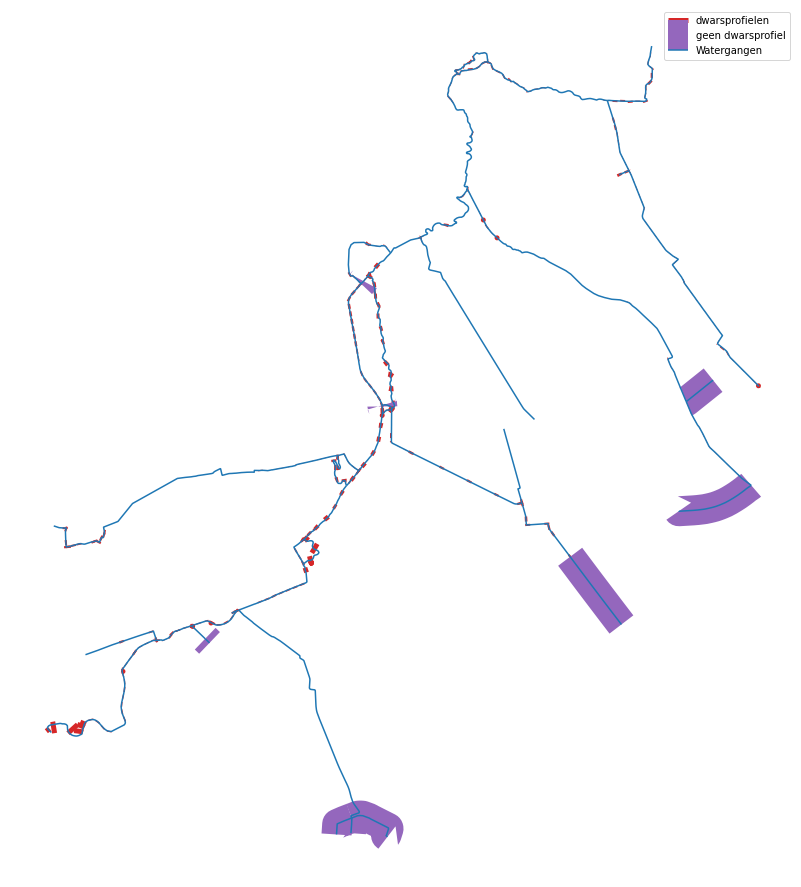

In [36]:
missing = dfmmodel.crosssections.get_branches_without_crosssection()
plt.rcParams['axes.edgecolor'] = 'w'
fig, ax = plt.subplots(figsize=(16, 16))

hydamo.profile.plot(ax=ax, color='C3', label='dwarsprofielen', linewidth=5)
hydamo.branches.loc[missing,:].plot(ax=ax, color='C4', label='geen dwarsprofiel',linewidth=30)
hydamo.branches.plot(ax=ax, label='Watergangen')
#gpd.read_file('../gis/roer_hoofdtak.shp').plot(ax=ax, color='C5', label='hoofdtak Roer',linewidth=4, alpha=0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend()

Partly, missing crosssections can be resolved by interpolating over the main branch. We set all branches with identical names to the same order numbers and assign those to the branches. D-Hydro will then interpolate the cross-sections over the branches.

In [37]:
j=0
hydamo.branches['order'] = np.nan
for i in hydamo.branches.naam.unique():
    if i != None:
        if all(x in missing for x in hydamo.branches.loc[hydamo.branches.loc[:,'naam']==i, 'code']) == False:
            hydamo.branches.loc[hydamo.branches.loc[:,'naam']==i, 'order'] = int(j)
            j=j+1

interpolation=[]
for i in hydamo.branches.itertuples():
    if i.order > 0:
        dfmmodel.network.set_branch_order(hydamo.branches.loc[i.Index,'code'], idx= int(hydamo.branches.at[i.Index,'order']))
        interpolation.append(hydamo.branches.loc[i.Index,'code'])

In [38]:
missing_after_interpolation =np.setdiff1d(missing,interpolation)
print('After interpolation', len(missing_after_interpolation), 'crosssections are missing.')

After interpolation 3 crosssections are missing.


Plot the branches that are still missing after interpolation:

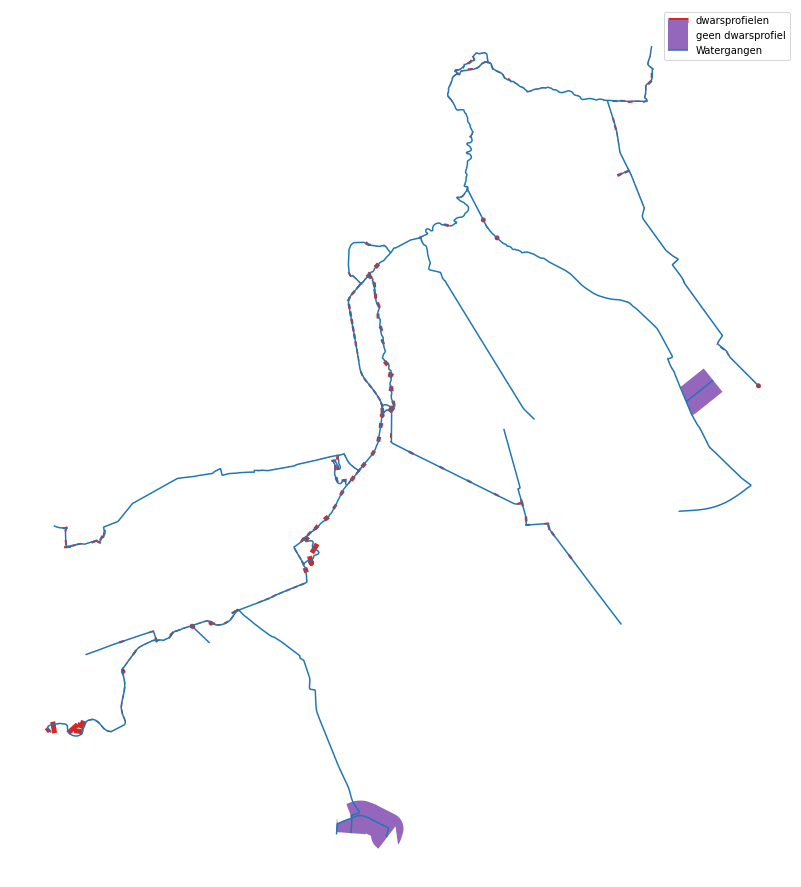

In [39]:
plt.rcParams['axes.edgecolor'] = 'w'
fig, ax = plt.subplots(figsize=(16, 16))

hydamo.profile.plot(ax=ax, color='C3', label='dwarsprofielen', linewidth=5)
hydamo.branches.loc[missing_after_interpolation,:].plot(ax=ax, color='C4', label='geen dwarsprofiel',linewidth=30)
hydamo.branches.plot(ax=ax, label='Watergangen')
#gpd.read_file('../gis/roer_hoofdtak.shp').plot(ax=ax, color='C5', label='hoofdtak Roer',linewidth=4, alpha=0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.legend()

If there are still missing cross sections left, a default one can be added. To do so, add a cross section definition, and assign it with a vertical offset (shift). To prevent that default definitions are assigned to locations that will be interpolated, these locations can be specified.

In [40]:
# Set a default cross section
default = dfmmodel.crosssections.add_rectangle_definition(
    height=5.0, width=5.0, closed=False, roughnesstype='Strickler', roughnessvalue=30, name='default')
dfmmodel.crosssections.set_default_definition(definition=default, shift=18.0)
dfmmodel.crosssections.set_default_locations(missing_after_interpolation)

### Boundary condititions

Boundary conditions can be set from HyDAMO (as previously read) or added here. Here, because we use a subset of the Oostrumsche beek, we read the downstream water level boundary from the DAMO2.2 data and add a discharge boundary condition at the upper boundary.

In [41]:
dfmmodel.external_forcings.io.from_hydamo(hydamo.boundary_conditions)
dfmmodel.external_forcings.add_boundary_condition('RVW_01', (197464.,392130.),  'discharge', 2.0)

### Initial conditions

Set the initial water depth to 0.5 m. It is also possible to set a global water level using the equivalent function "set_initial_waterlevel".

In [42]:
# # Initial water depth is set to 0.5 m
dfmmodel.external_forcings.set_initial_waterdepth(0.5)

### Generate the 2D mesh

To add a mesh, currently 2 options exist:

1) the converter can generate a relatively simple, rectangular mesh, with a rotation or refinement. Note that rotation _and_ refinement is currently not possible. In the section below we generate a refined 2D mesh with the following steps:

- Generate grid within a polygon. The polygon is the extent given to the HyDAMO model.
- Refine along the main branch
- Determine altitude from a DEM.

The 'refine'-method requires the dflowfm.exe executable. If this is not added to the system path, it can be provided in an optional argument to refine (dflowfm_path).

In [43]:
# Create mesh object
mesh = Rectangular()
cellsize = 25

# Generate mesh within model bounds
if float('.'.join(python_version().split('.')[0:2])) >= 3.8:
    os.add_dll_directory(dll_path)
buffer = hydamo.branches.geometry.unary_union.buffer(500.)
mesh.generate_within_polygon(buffer, cellsize=cellsize, rotation=0)

# Refine the model (2 steps) along the main branch. To do so we generate a buffer around the main branch.
buffered_branch = hydamo.branches.loc[['W_242223_0', 'W_242224_0'], 'geometry'].unary_union.buffer(10)

# optional: only possible with dflowfm.exe
mesh.refine(polygon=[buffered_branch], level=[2], cellsize=cellsize, dflowfm_path=dflowfm_path)

# Determine the altitude from a digital elevation model
rasterpath = '../data/rasters/AHN.tif'
mesh.altitude_from_raster(rasterpath)

# The full DEM is not added to this notebook. Instead a constant bed level is used
# mesh.altitude_constant(20.0)
# The full DEM is not added to this notebook. Instead a constant bed level is used
# mesh.altitude_constant(20.0)

# Add to schematisation
dfmmodel.network.add_mesh2d(mesh)

2022-06-20 13:45:41,571 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Generating grid with cellsize 25 m and rotation 0 degrees.
2022-06-20 13:45:41,839 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Selecting nodes within polygon.
2022-06-20 13:45:42,114 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Creating LineString for each edge.
2022-06-20 13:45:43,571 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Checking for intersections.
2022-06-20 13:45:44,166 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Remove edges with only a single node within the clip area.
2022-06-20 13:45:53,743 - delft3dfmpy.core.mesh2d - mesh2d - INFO - Creating GeoDataFrame of cell faces.
2022-06-20 13:45:56,396 - delft3dfmpy.core.geometry - logging - INFO - Processing raster:   0 %
2022-06-20 13:45:56,406 - delft3dfmpy.core.geometry - logging - INFO - Processing raster:  10 %
2022-06-20 13:45:56,417 - delft3dfmpy.core.geometry - logging - INFO - Processing raster:  20 %
2022-06-20 13:45:56,427 - delft3dfmpy.core.geometry - 

2) a more complex mesh can be created in other software (such as SMS) and then imported in the converter: (uncomment to activate)

In [44]:
#from dhydamo.core.mesh2d import Mesh2D
#mesh = Mesh2D()
# import the geometry
#mesh.geom_from_netcdf(r'T:\2Hugo\Grid_Roer_net.nc')
# fill every cell with an elevation value
#mesh.altitude_from_raster(rasterpath)
# and add to the model
#dfmmodel.network.add_mesh2d(mesh)

### Add 1D2D-links

For linking the 1D and 2D model, three options are available:
1. Generating links from each 1d node to the nearest 2d node.
2. Generating links from each 2d node to the nearest 1d node (intersecting==True)
3. Generating links from each 2d node to the nearest 1d node, while not allowing the links to intersect other cells (intersecting==False).

Intersecting indicates whether or not the 2D cells cross the 1D network (lateral versus embedded links).
So, option 3 is relevant when there is no 2d mesh on top of the 1d mesh: the lateral links.

Note that for each option a maximum link length can be chosen, to prevent creating long (and perhaps unrealistic) links.

In [45]:
del dfmmodel.network.links1d2d.faces2d[:]
del dfmmodel.network.links1d2d.nodes1d[:]
dfmmodel.network.links1d2d.generate_1d_to_2d()

2022-06-20 13:46:03,660 - delft3dfmpy.core.dfm - dfm - INFO - Generating links from 1d to 2d based on distance.


In [46]:
dfmmodel.network.links1d2d.remove_1d_endpoints()

2022-06-20 13:46:03,724 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (198504.24, 392720.68) because it is connected to an end-point.
2022-06-20 13:46:03,725 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (198650.03, 392914.88) because it is connected to an end-point.
2022-06-20 13:46:03,727 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (201199.27, 395801.30) because it is connected to an end-point.
2022-06-20 13:46:03,727 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (199435.10, 391468.31) because it is connected to an end-point.
2022-06-20 13:46:03,728 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (199340.02, 391459.66) because it is connected to an end-point.
2022-06-20 13:46:03,729 - delft3dfmpy.core.dfm - dfm - INFO - Removed link(s) from 1d node: (201818.74, 394450.02) because it is connected to an end-point.
2022-06-20 13:46:03,730 - delft3dfmpy.core.dfm - dfm - INFO - Re

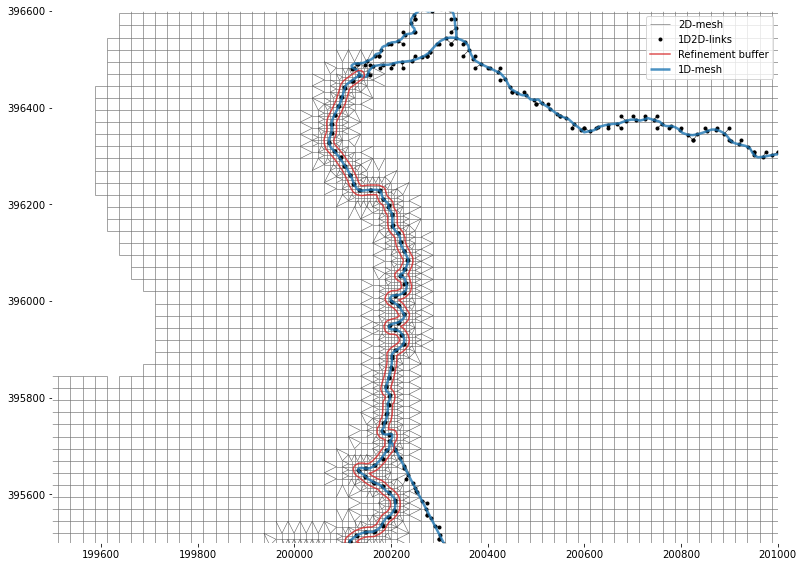

In [47]:
fig, ax = plt.subplots(figsize=(13, 10))
ax.set_aspect(1.0)

segments = dfmmodel.network.mesh2d.get_segments()
ax.add_collection(LineCollection(segments, color='0.3', linewidths=0.5, label='2D-mesh'))

links = dfmmodel.network.links1d2d.get_1d2dlinks()
ax.add_collection(LineCollection(links, color='k', linewidths=0.5))
ax.plot(links[:, :, 0].ravel(), links[:, :, 1].ravel(), color='k', marker='.', ls='', label='1D2D-links')

for i, p in enumerate([buffered_branch]):
    ax.plot(*p.exterior.xy, color='C3', lw=1.5, zorder=10, alpha=0.8, label='Refinement buffer' if i==0 else None)

hydamo.branches.plot(ax=ax, color='C0', lw=2.5, alpha=0.8, label='1D-mesh')

ax.legend()

ax.set_xlim(199500, 201000)
ax.set_ylim(395500, 396600);

### Observation points

Observation points are now written in the new format, where once can discriminate between 1D ('1d') and 2D ('2d') observation points. This can be done using the optional argument 'locationTypes'. If it is omitted, all points are assumed to be 1d. 1D-points are always snapped to a the nearest branch. 2D-observation points are always defined by their X/Y-coordinates. 

Note: add_points can be called only once: once dfmodel.observation_points is filled,the add_points-method is not available anymore. Observation point coordinates can be definied eiher as an (x,y)-tuple or as a shapely Point-object.

In [48]:
dfmmodel.observation_points.add_points([Point((200200,395600)),(200200,396200)],['ObsPt1','ObsPt2'], locationTypes=['1d','1d'], snap_distance=10.)

## Generate the RR schematization

Catchments are provided in the HyDAMO DAMO2.2 format and included in the GPKG. They can also be read from other formats using 'read_gml', or 'read_shp'. Note that in case of shapefiles column mapping is necessary because the column names are truncated. 

Note that when catchments have a "MultiPolygon' geometry, the multipolygons are 'exploded' into single polygon geometries. A warning of this is isued, and a suffix is added to every polygons ID to prevent duplicates. 

For every catchment, the land use areas will be calculated and if appopriate a maximum of four RR-nodes will be created per catchment:
 - unpaved (based on the Ernst concept)
 - paved 
 - greenhouse
 - open water (not the full Sobek2 open water, but only used to transfer (net) precipitation that falls on open water that is schematized in RR to the 1D/2D network.
 
At the moment, two options exist for the schematisation of the paved area:
 1) simple: the paved fraction of each catchment is modelled with a paved node, directly connected to catchments' boundary node
 <br>
 2) more complex: sewer area polygons and overflow points are used a input as well. For each sewer area, the overlapping paved area is the distributed over the overflows that are associated with the sewerarea (the column 'lateraleknoopcode') using the area fraction (column 'fractie') for each overflow. In each catchment, paved area that does not intersect with a sewer area gets an unpaved node as in option (1).

First read sewer areas and overflow locations.

In [49]:
hydamo.sewer_areas.read_shp(os.path.join(data_path , 'GPKG',  'rioleringsgebieden.shp'),clip=None, check_geotype=False, column_mapping={'Code':'code'})
hydamo.overflows.read_shp(os.path.join(data_path,  'GPKG' , 'overstorten.shp') ,clip=None, column_mapping={'codegerela':'codegerelateerdobject', 'naam_riole':'name' })
hydamo.overflows.snap_to_branch(hydamo.branches, snap_method='overal', maxdist= 5000)

Create in instance of a DFlowRRModel and set the parameters.

Other input data for RR can be fed by rasters (from which zonal statistics will be extracted) or spatially uniform default values. Three rasters are required: land use, soil type and surface elevation. For each land use type, the area within each catchment is calculated. Surface level is calculated as the median within the catchment, and the most-occurring soil type is used. In all rasters, a NODATA-value of -999 should be used.

In [50]:
drrmodel = DFlowRRModel()

For land use and soil type a coding is prescribed. For landuse, the legend of the map is expected to be as follows: <br>
 1 potatoes  <br>
 2 wheat<br>
 3 sugar beet<br> 
 4 corn       <br> 
 5 other crops <br> 
 6 bulbous plants<br> 
 7 orchard<br>
 8 grass  <br>
 9 deciduous forest  <br>
10 coniferous forest<br>
11 nature<br>
12 barren<br>
13 open water<br>
14 built-up<br>
15 greenhouses<br>

For classes 1-12, the areas are calculated from the provided raster and remapped to the classification in the Sobek RR-tables.


The coding for the soil types:<br>
1 'Veengrond met veraarde bovengrond'<br>
 2 'Veengrond met veraarde bovengrond, zand'<br>
 3 'Veengrond met kleidek'<br>
 4 'Veengrond met kleidek op zand'<br>
 5 'Veengrond met zanddek op zand'<br>
 6 'Veengrond op ongerijpte klei'<br>
 7 'Stuifzand'<br>
 8 'Podzol (Leemarm, fijn zand)'<br>
 9 'Podzol (zwak lemig, fijn zand)'<br>
10 'Podzol (zwak lemig, fijn zand op grof zand)'<br>
11 'Podzol (lemig keileem)'<br>
12 'Enkeerd (zwak lemig, fijn zand)'<br>
13 'Beekeerd (lemig fijn zand)'<br>
14 'Podzol (grof zand)'<br>
15 'Zavel'<br>
16 'Lichte klei'<br>
17 'Zware klei'<br>
18 'Klei op veen'<br>
19 'Klei op zand'<br>
20 'Klei op grof zand'<br>
21 'Leem'<br>


And surface elevation needs to be in m+NAP.

### Unpaved areas

Fill the unpaved node with the corresponding ernst definition as follows. 

The argument 'meteo_areas' to 'unpaved_from_input' contains the polygons that correspond to a meteo-station: here these are identical to each catchment so each catchment gets its own station.  If there are many, small, catchments, it might be more appropriate to use, for instance, Thiessen polygons around gauges. For each catchment, the meteo-station is based on the 'meteo-area;-feature in which the centroid of the catchment falls.

The argument 'zonalstats_alltouched' is rather important. It defines the number of cells in the input rasters that are taken into account for each catchment. If the raster resolution is sufficiently high, its setting does not matter. In the case of coarse rasters, small catchments might end up with no nodes at all if the 'zonalstats_alltouched' is FALSE - it says that only cells of which the centroids are inside the polygon are taken into account. If it is TRUE, all cells that are touched by the catchment geometry are taken into account - i.e. some pixels might be counted multiple times. Note that to define average fluxes (meteo, seepage, storages) zonalstats_alltouched is TRUE by default. For elevation, land use and soil types it is FALSE by default, if the argument is omitted.

In [51]:
# # all data and settings to create the RR-model
# all data and settings to create the RR-model
lu_file = os.path.join(data_path , 'rasters' ,'sobek_landuse.tif')
ahn_file = os.path.join(data_path ,'rasters' , 'AHN.tif')
soil_file = os.path.join(data_path , 'rasters' , 'sobek_soil.tif')
surface_storage = 10.0
infiltration_capacity = 100.0
initial_gwd = 0.4 # water level depth below surface

runoff_resistance = 1.
infil_resistance = 300.
layer_depths = [0.0, 1.0, 2.0]
layer_resistances = [30,200,10000]

meteo_areas = hydamo.catchments

drrmodel.unpaved.io.unpaved_from_input(hydamo.catchments, lu_file, ahn_file, soil_file, surface_storage, infiltration_capacity, initial_gwd, meteo_areas, zonalstats_alltouched=True)
drrmodel.unpaved.io.ernst_from_input(hydamo.catchments, depths=layer_depths, resistance=layer_resistances,infiltration_resistance=infil_resistance, runoff_resistance=runoff_resistance)

### Paved areas

Input for the paved nodes are land use -the area of the paved node is the area of class '14' in the provided land use map- and surface elevation. In addition, the following parameters can all be numbers (spatially uniform) or raster filenames:
- storage on the street (in mm)<br>
- storage in the sewer system (in mm)<br>
- capacity of the sewerpumps (in m3/s)<br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [52]:
street_storage = 10.0
sewer_storage =  10.0 #s.path.join(data_path,'rasters/sewstor.tif')
pumpcapacity =  10.0 #os.path.join(data_path,'rasters/pumpcap.tif')

# version with sewer areas and overflows
drrmodel.paved.io.paved_from_input(catchments=hydamo.catchments, 
                                    overflows=hydamo.overflows,
                                    sewer_areas=hydamo.sewer_areas,                                   
                                    landuse=lu_file, 
                                    surface_level=ahn_file,
                                    street_storage=street_storage,
                                    sewer_storage=sewer_storage,
                                    pump_capacity=pumpcapacity, 
                                    meteo_areas=meteo_areas,
                                    zonalstats_alltouched=True)

# ...and simply one paved node per catchment
# drrmodel.paved.io.paved_from_input(catchments=hydamo.catchments, 
#                                     landuse=lu_file, 
#                                     surface_level=ahn_file,
#                                     street_storage=street_storage,
#                                     sewer_storage=sewer_storage,
#                                     pump_capacity=pumpcapacity, 
#                                     meteo_areas=meteo_areas)

2022-06-20 13:46:11,120 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 71.0_0


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 71.0_0


2022-06-20 13:46:11,136 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 71.0_1


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 71.0_1


2022-06-20 13:46:11,798 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 298.0


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 298.0


2022-06-20 13:46:11,955 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 307.0


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 307.0


2022-06-20 13:46:12,292 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 432.0


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 432.0


2022-06-20 13:46:12,724 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - No paved area outside sewer area in catchments 882.0_1


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:No paved area outside sewer area in catchments 882.0_1


### Greenhouse areas

Input for the greenhouse nodes are (again) land use -the area of the paved node is the area of class '15' in the provided land use map- and surface elevation. In addition, the following parameter can be a number (spatially uniform) or a raster filename:
- storage on the roof <br>

The meteo-station is assigned in the same way as for unpaved nodes.

In [53]:
roof_storage = 10.0 #os.path.join(data_path,'rasters/roofstor.tif')
drrmodel.greenhouse.io.greenhouse_from_input(hydamo.catchments, lu_file, ahn_file, roof_storage, meteo_areas, zonalstats_alltouched=True)

### Open water areas

Input for the open water nodes are only land use -the area of the paved node is the area of class '13' in the provided land use map. 

The meteo-station is assigned in the same way as for unpaved nodes.

In [54]:
drrmodel.openwater.io.openwater_from_input(hydamo.catchments, lu_file, meteo_areas, zonalstats_alltouched=True)

### Boundary nodes

Boundary nodes are assumed to be also included in the FM-model. For every catchment, the boundary identified by 'lateraleknoopocode' in the catchment definitition, is assumed to exist in the laterals. 

These nodes are created in the RR model with the same ID. 'drrmodel' is an argument because the function checks whether boundary nodes have a valid connection to anyo other node; other boundaries are removed. Overflows are optional and can be left out. If they are included, additional boundaries are created.

In [55]:
drrmodel.external_forcings.io.boundary_from_input(hydamo.laterals, hydamo.catchments, drrmodel, overflows=hydamo.overflows)

2022-06-20 13:46:18,091 - delft3dfmpy.converters.hydamo_to_dflowrr - hydamo_to_dflowrr - INFO - Adding overflows to the boundary nodes.


INFO:delft3dfmpy.converters.hydamo_to_dflowrr:Adding overflows to the boundary nodes.


Coupling between RR and FM must be online (parallel), not sequential. RR reads waterlevels from FM laterals and FM gets discharges from lateral nodes of discharge type 'realtime'. In the call to the function, the overflow locations are appended to the regular lateral locations. For lateral nodes for which no rr_boundary (catchment or overflow) exists, a time series from lateral_discharge is used. Lateral discharges can be of two types:
- a Pandas series, that contains one number (in m3/s) for every lateral. The 'code' of the lateral should be the index of the series. See example below.
- a Pandas dataframe containing time series, with a column for every lateral node. The 'code' of the lateral should be equal to the column names, and the index should contain the timestamps.

In [56]:
dfmmodel.external_forcings.io.read_laterals(locations=hydamo.laterals.append(hydamo.overflows), lateral_discharges=None, rr_boundaries=drrmodel.external_forcings.boundary_nodes)

### External forcings

Three types of external forcing need to be provided:<br>
- Seepage/drainage
- Precipitation
- Evaporation

All are assumed to be spatially variable and thus need to pe provided as rasters per time step. Only the locations of the folders containing the rasters need to be provided; the time step is then derived from the file names.

Precipitation and evaporation are assumed to be in mm/d. As for evaporation only one meteostation is used, the meteo_areas are dissolved. For seepage, as the use of Metaswap-rasters is allowed, the unit is assumed to m3/grid cell/timestep.

Rastertypes can be any type that is recognized by rasterio (in any case Geotiff and ArcASCII rasters). If the file extension is 'IDF', as is the case in Modflow output, the raster is read using the 'imod'-package.

IMPORTANT: time steps are extracted from the file names. Therefore, the names should cohere to some conditions:
The filename should consist of at least two parts, separated by underscores. The second part needs to contain time information, which should be formatted as YYYYMMDDHHMMSS (SS may be omitted). Or, for daily data YYYYMMDD.

For example: 'precip_20200605151500.tif'

In [57]:
seepage_folder = os.path.join( data_path, 'rasters', 'seepage')
precip_folder =  os.path.join(data_path, 'rasters',  'precipitation')
evap_folder = os.path.join( data_path, 'rasters',  'evaporation')

drrmodel.external_forcings.io.seepage_from_input(hydamo.catchments, seepage_folder)
drrmodel.external_forcings.io.precip_from_input(meteo_areas, precip_folder)
drrmodel.external_forcings.io.evap_from_input(meteo_areas, evap_folder)

Reading seepage files:   0%|          | 0/3 [00:00<?, ?it/s]

Reading precipitation files:   0%|          | 0/72 [00:00<?, ?it/s]

Reading evaporation files:   0%|          | 0/3 [00:00<?, ?it/s]

## Plotting and writing

We need a function to plot the RR-nodes

In [58]:
def node_geometry(dict):
    # Function to put the node geometries in geodataframes
    from shapely.geometry import Point
    geoms = []  
    links = []
    for i in dict.items():
        if 'ar' in i[1]:
            if np.sum([float(s) for s in i[1]['ar'].split(' ')])>0:
                geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
                links.append(LineString((Point(float(i[1]['px']),float(i[1]['py'])),
                                        Point(float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['px']),
                                              float(drrmodel.external_forcings.boundary_nodes[i[1]['boundary_node']]['py'])))))
        else: 
            geoms.append(Point((float(i[1]['px']),float(i[1]['py']))))           
    return((gpd.GeoDataFrame(geoms,columns=['geometry'])),gpd.GeoDataFrame(links,columns=['geometry']))

Now all the nodes are filled. The topology is defined as follows: every catchment gets a maximum of four nodes (unpaved, paved, open water and greenhouse). If in the land use map, the appropriate land use does not occur in the catchment, no node is defined. The four nodes are plotted on a horizontal (west-east) line around the catchment centroid in the order of: openwater, unpaved, paved, greenhouse. Every node is connected with the lateral node of the catchnment using a RR-link. The files 3B_NOD.TP and 3B_LINK.TP are created describing this.

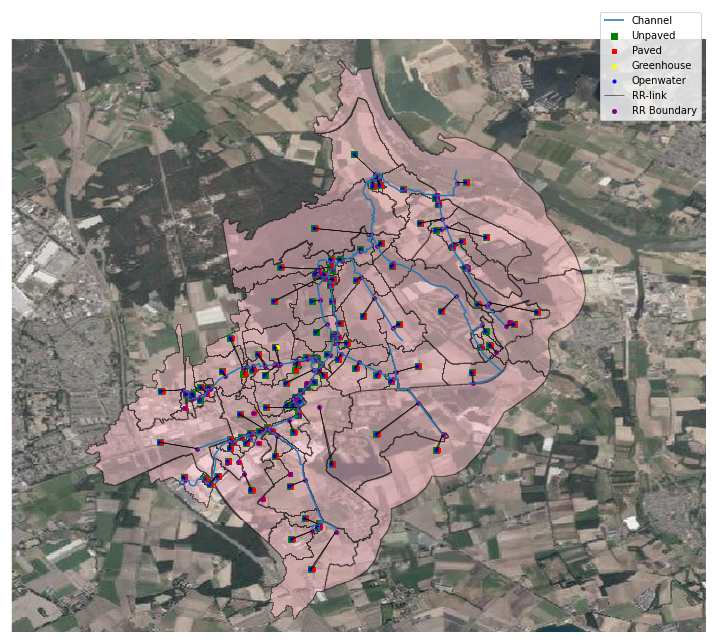

In [59]:
## plt.rcParams['axes.edgecolor'] = 'w'
import matplotlib.patches as mpatches
fig, ax = plt.subplots(figsize=(10, 10))

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(195000, 205000)
ax.set_ylim(390000, 399000)

achtergrond = plt.imread( os.path.join(data_path,'gis/achtergrond_oostrum.png'))
ax.imshow(achtergrond, extent=(189287, 210845, 389693, 398529), interpolation='lanczos')

hydamo.catchments.plot(ax=ax,label='Catchments', edgecolor='black', facecolor="pink", alpha=0.5)
hydamo.branches.plot(ax=ax, label='Channel')
node_geometry(drrmodel.unpaved.unp_nodes)[0].plot(ax=ax,markersize=30,marker='s',color='green',label='Unpaved')
node_geometry(drrmodel.unpaved.unp_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.paved.pav_nodes)[0].plot(ax=ax,markersize=20,marker='s',color='red',label='Paved')
node_geometry(drrmodel.paved.pav_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.greenhouse.gh_nodes)[0].plot(ax=ax,markersize=15,color='yellow',label='Greenhouse')
node_geometry(drrmodel.greenhouse.gh_nodes)[1].plot(ax=ax, color='black',linewidth=0.5)
node_geometry(drrmodel.openwater.ow_nodes)[0].plot(ax=ax,markersize=10,color='blue',label='Openwater')
node_geometry(drrmodel.openwater.ow_nodes)[1].plot(ax=ax, color='black',linewidth=0.5,label='RR-link')
node_geometry(drrmodel.external_forcings.boundary_nodes)[0].plot(ax=ax, markersize=15, color='purple',label='RR Boundary')

# manually add handles for polygon plot
handles, labels = ax.get_legend_handles_labels()
poly = mpatches.Patch(facecolor='pink', edgecolor='black',alpha=0.5)
ax.legend(handles=handles.append(poly),labels=labels.append('Catchments'))
fig.tight_layout()

### Settings and writing

Finally, we adjust some settings and export the coupled FM-RR model. For more info on the settings: https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf

The 1D/2D model (FM) is written to the sub-folder 'fm'; RR-files are written to 'rr'. An XML-file (dimr-config.xml) describes the coupling between the two. 

For every paved node, a sewage link to a WWTP is created. This is not included in the data, and will be created (including a boundary outside the model) at the coordinates specified by the 'wwtp' argument in the rr_writer below.

In [60]:
# for FM model
dfmmodel.mdu_parameters['refdate'] = 20160601
dfmmodel.mdu_parameters['tstart'] = 0.0 * 3600
dfmmodel.mdu_parameters['tstop'] =  24.0 * 3600
dfmmodel.mdu_parameters['hisinterval'] = '120. 0. 0.'
dfmmodel.mdu_parameters['cflmax'] = 0.7
dfmmodel.mdu_parameters['OutputDir'] = 'output'
dfmmodel.mdu_parameters['useVolumeTables'] = 1 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['increment'] = 0.2 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcFormat'] = 4 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcNoForcedFlush'] = 1 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['MapFormat'] = 4 # oparameter setting advised by Deltares for better performance
dfmmodel.mdu_parameters['NcNoUnlimited'] = 1 # oparameter setting advised by Deltares for better performance

# # for RR model
drrmodel.d3b_parameters['Timestepsize'] = 300
drrmodel.d3b_parameters['StartTime'] = "'2016/06/01;00:00:00'" # should be equal to refdate for D-HYDRO
drrmodel.d3b_parameters['EndTime'] = "'2016/06/03;00:00:00'"
drrmodel.d3b_parameters['RestartIn'] = 0
drrmodel.d3b_parameters['RestartOut'] = 0
drrmodel.d3b_parameters['RestartFileNamePrefix'] ='Test'
drrmodel.d3b_parameters['UnsaturatedZone'] = 1
drrmodel.d3b_parameters['UnpavedPercolationLikeSobek213']=-1
drrmodel.d3b_parameters['VolumeCheckFactorToCF']=100000
drrmodel.dimr_path = dimr_path
print('Writing model')

# # Create writer
fm_writer = DFlowFMWriter(dfmmodel, output_dir= output_path, name='demo')
rr_writer = DFlowRRWriter(drrmodel, output_dir= output_path, name='demo',wwtp=(199000.,396000.))

# # Write as model
# # The ldb is just for visualising in the interaktor - there is no RR component there.
fm_writer.objects_to_ldb()
fm_writer.write_all()
rr_writer.write_all()

Writing model


Finished! Start the coupled model by clicking run.bat in the output model, or import the dimr_config.xml in the GUI.